# ROC & PrAUC Optimization



In [1]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

# Data

Imbalanced Data 를 생성합니다. <br>
이때 make_classification 함수를 사용하면 좋습니다. 

In [2]:
x_data, y_data = make_classification(
    n_samples=10000,
    n_features=5,
    n_classes=2,
    weights=(0.9, 0.1),
    flip_y=0.05,
    random_state=1,
)

x_data = pd.DataFrame(x_data, columns=["x1", "x2", "x3", "x4", "x5"])
y_data = pd.DataFrame(y_data.reshape(-1, 1), columns=["y"])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=2)

# Display Data
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)
display(y_data.value_counts())
display(x_data.join(y_data).head())

x_train: (7000, 5)
y_train: (7000, 1)
x_test : (3000, 5)
y_test : (3000, 1)


y
0    8781
1    1219
dtype: int64

,x1,x2,x3,x4,x5,y
0,-1.001202,-1.144739,0.542759,-1.213478,-1.515303,0
1,0.762951,-0.367625,0.055824,-1.785367,0.564202,0
2,-0.705091,0.273111,-0.026364,-0.598962,-0.553148,0
3,1.925754,-1.470852,0.346450,-0.684048,1.165529,0
4,1.520116,-1.642537,0.455763,1.206765,0.690714,0


# Logistic Regression



In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="lbfgs")
model.fit(x_train, y_train.values.reshape(-1))

y_prob = model.predict_proba(x_test)[:, 1]

## ROC Curve and AUC

**AUC**
- 0.5: 전혀 못 맞춤
- 1: 다 맞춤


Logistic: ROC AUC=0.858



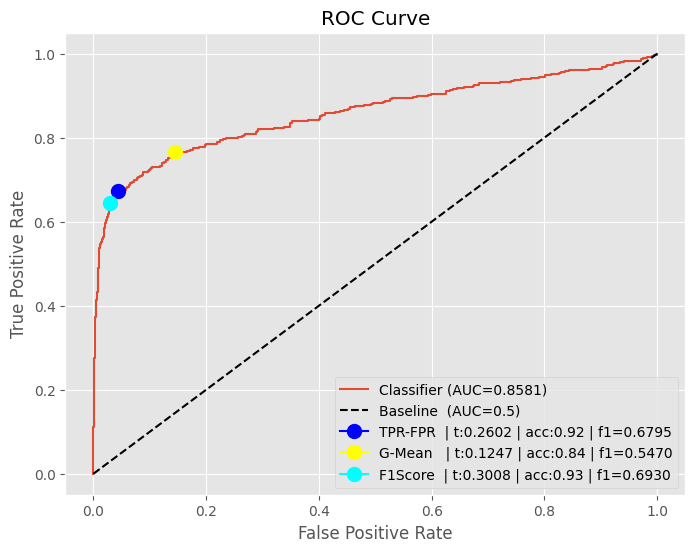

In [76]:
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)


def make_mark(_idx, color, label):
    _max_threshold = thresholds[_idx]
    _acc = accuracy_score(y_test, y_prob >= _max_threshold)
    _f1 = f1_score(y_test, y_prob >= _max_threshold)
    _precision = precision_score(y_test, y_prob >= max_threshold)
    _recall = recall_score(y_test, y_prob >= max_threshold)
    label = f"{label:8} | t:{_max_threshold:.4f} | acc:{_acc:.2f} | f1={_f1:.4f}"
    plot.plot(fpr[_idx], tpr[_idx], marker="o", markersize=10, color=color, label=label)


# ROC AUC
lr_auc = roc_auc_score(y_test, y_prob)
print("Logistic: ROC AUC=%.3f" % (lr_auc))


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# TPR - FPR Optimal Threshold
idx1 = np.argmax(tpr - fpr)
max_threshold = thresholds[idx1]


# G-Means Optimal Threshold
gmeans = np.sqrt(tpr * (1 - fpr))
idx2 = np.argmax(gmeans)
max_threshold = thresholds[idx2]


# F1 Scores
scores = [f1_score(y_test, y_prob > t) for t in thresholds]
idx3 = np.argmax(scores)


fig, plot = plt.subplots(1, figsize=(8, 6))
plot.plot(fpr, tpr, label=f"Classifier (AUC={auc(fpr, tpr):.4f})")
plot.plot([0, 1], [0, 1], "k--", label=f"Baseline  (AUC=0.5)")

make_mark(idx1, "blue", f"TPR-FPR")
make_mark(idx2, "yellow", "G-Mean")
make_mark(idx3, "cyan", "F1Score")

plot.set_xlabel("False Positive Rate")
plot.set_ylabel("True Positive Rate")
plot.set_title(f"ROC Curve")
plot.legend(loc="lower right")
print()

# PRAUC

이후 특정 Threshld 의 AUC 를 계산 하는 방법은 다음과 같이 합니다. 

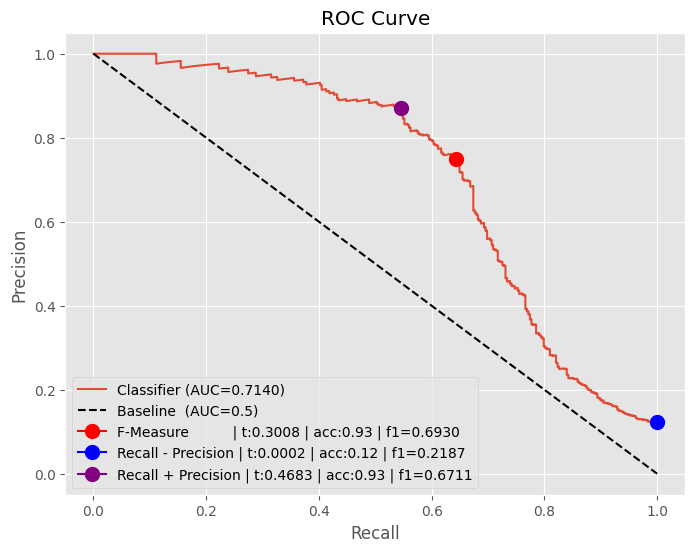

In [105]:
from sklearn.metrics import auc, precision_recall_curve


def make_mark(_idx, color, label):
    _max_threshold = thresholds[_idx]
    _acc = accuracy_score(y_test, y_prob >= _max_threshold)
    _f1 = f1_score(y_test, y_prob >= _max_threshold)
    label = f"{label:18} | t:{_max_threshold:.4f} | acc:{_acc:.2f} | f1={_f1:.4f}"
    plot.plot(recall[_idx], precision[_idx], marker="o", markersize=10, color=color, label=label)


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)


# F-Measure (F1-Score)
fscores = 2 * (precision * recall) / (precision + recall)
idx1 = np.argmax(fscores)

# recall - precision Optimal Threshold
idx2 = np.argmax(recall - precision)
max_threshold = thresholds[idx1]

# recall - precision Optimal Threshold
idx3 = np.argmax(recall + precision)
max_threshold = thresholds[idx1]


fig, plot = plt.subplots(1, figsize=(8, 6))
plot.plot(recall, precision, label=f"Classifier (AUC={auc(recall, precision):.4f})")
plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")

make_mark(idx1, "red", f"F-Measure")
make_mark(idx2, "blue", f"Recall - Precision")
make_mark(idx3, "purple", f"Recall + Precision")


plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"ROC Curve")
plot.legend(loc="lower left")

## 

# Threshold Tuning

모델 하나있고.. ROC 니.. PRAUC 니 그런거 모르겠고.. 
그냥 빠르게 찾고자 할때 사용하면 좋습니다. 

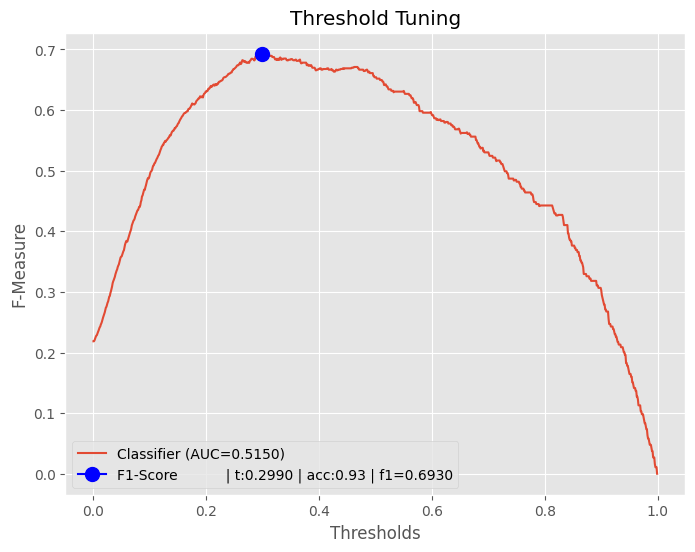

In [93]:
from sklearn.metrics import f1_score


def make_mark(_idx, color, label):
    _max_threshold = thresholds[_idx]
    _acc = accuracy_score(y_test, y_prob >= _max_threshold)
    _f1 = f1_score(y_test, y_prob >= _max_threshold)
    label = f"{label:18} | t:{_max_threshold:.4f} | acc:{_acc:.2f} | f1={_f1:.4f}"
    plt.plot(thresholds[_idx], scores[_idx], marker="o", markersize=10, color=color, label=label)


thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_test, y_prob >= t) for t in thresholds]
idx = np.argmax(scores)


roc_auc = auc(thresholds, scores)
fig, plot = plt.subplots(1, figsize=(8, 6))
plot.plot(thresholds, scores, label=f"Classifier (AUC={roc_auc:.4f})")

make_mark(idx, "blue", "F1-Score")

plot.set_title(f"Threshold Tuning")
plot.set_xlabel("Thresholds")
plot.set_ylabel("F-Measure")
plot.legend(loc="lower left")

## 특정 Threshold 에서의 AUC

정확하게 이런 방법은 ML책에 나오는 방법은 아닙니다. <br>
그래서 이런 지표에 대한 이름도 딱히 없습니다. <br> 
지난번 Baysian 공식을 엮으로 엮어서 casuality analysis 한것 처럼 우린 그냥 수식을 이용해서 문제를 해결할 뿐입니다.<br> 

특정 threshold 를 걸어주게되면, 이미 특정 threshold 기준으로 probability가 고정이 됩니다. <br>
이 기준을 해당 기준을 갖고서 AUC를 구했을때의 지표입니다.

예제는 다음과 같습니다. 
- target_threshold=0.3 : 해당 0.3 PRAUC 에서 F1-Score의 optimal threshold 입니다. 
- target_threshold=0.9 : 그냥 임의로 정한 값입니다. (비교를 위해서)

0.3 threshold의 경우는 AUC 0.7140이 나옵니다. <br>
0.9 threshold의 경우는 AUC 0.6253이 나옵니다. 

이런 방식을 사용해서 모델간의 성능을 비교하기도 합니다. <br>
다만.. 위에서 이야기 했듯이 공식적으로 있는 건 아니기 때문에 뭐라고 해야 할지 모르겠네요. 

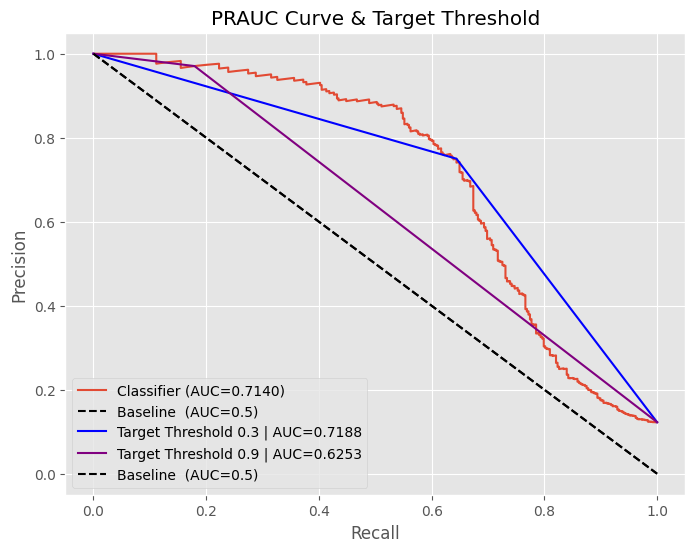

In [126]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# F-Measure (F1-Score)
fscores = 2 * (precision * recall) / (precision + recall)
idx1 = np.argmax(fscores)


# Plot
roc_auc = auc(recall, precision)
fig, plot = plt.subplots(1, figsize=(8, 6))
plot.plot(recall, precision, label=f"Classifier (AUC={roc_auc:.4f})")
plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")


# Threshold 0.3 에서의 AUC
target_threshold = 0.3
precision, recall, thresholds = precision_recall_curve(y_test, y_prob >= target_threshold)
plot.plot(recall, precision, color='blue', label=f"Target Threshold {target_threshold} | AUC={auc(recall, precision):.4f}")

# Threshold 0.9 에서의 AUC
target_threshold = 0.9
precision, recall, thresholds = precision_recall_curve(y_test, y_prob >= target_threshold)
plot.plot(recall, precision, color='purple', label=f"Target Threshold {target_threshold} | AUC={auc(recall, precision):.4f}")


plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")

plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"PRAUC Curve & Target Threshold")
plot.legend(loc="lower left")

In [112]:
np.unique(thresholds).shape

(2998,)